In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
import joblib
import matplotlib.pyplot as plt

In [2]:
# Custom Mish activation function
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

In [3]:
# Register the custom activation
tf.keras.utils.get_custom_objects().update({'mish': tf.keras.layers.Activation(mish)})

In [4]:
# -------------------------------------------------------------------------
# Data Preprocessing
# -------------------------------------------------------------------------
def preprocess_data(file_path, test_size=0.2, random_state=42):
    """
    Load and preprocess dataset for ANIDS.
    - Applies robust scaling
    - Removes outliers using IQR
    - Splits data into training & validation sets
    """
    df = pd.read_csv(file_path)
    y = df['Attack_label']
    X = df.drop(['Attack_label'], axis=1)
    
    # Outlier removal using IQR
    Q1, Q3 = X.quantile(0.25), X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - 3 * IQR)) | (X > (Q3 + 3 * IQR))).any(axis=1)
    X = X[mask]
    y = y[mask]
    
    # Scaling
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    joblib.dump(scaler, 'robust_scaler.pkl')

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    return X_train, X_val, y_train, y_val

In [5]:
# -------------------------------------------------------------------------
# Layer 1: Anomaly Detection
# -------------------------------------------------------------------------
class AdaptiveNIDSLayer1:
    def __init__(self, input_dim, latent_dim=16):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.model = self._build_autoencoder()

    def _build_autoencoder(self):
        inputs = layers.Input(shape=(self.input_dim,))
        x = layers.BatchNormalization()(inputs)
        x = layers.Reshape((-1, 1))(x)

        # Feature extraction via Residual CNN
        conv1 = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
        conv2 = layers.Conv1D(32, 3, activation='relu', padding='same')(conv1)
        # Add residual connection
        res = layers.Conv1D(32, 1, padding='same')(conv1)
        x = layers.Add()([conv2, res])
        x = layers.GlobalAveragePooling1D(name="gap_layer")(x)

        # Latent Representation
        x = layers.Dense(64, activation=mish, kernel_regularizer=regularizers.l1(0.0005))(x)
        x = layers.Dropout(0.3)(x)
        encoded = layers.Dense(self.latent_dim, activation='linear')(x)

        # Decoder
        x = layers.RepeatVector(self.input_dim)(encoded)
        x = layers.LSTM(self.latent_dim * 2, return_sequences=True, recurrent_dropout=0.25)(x)
        decoded = layers.TimeDistributed(layers.Dense(1, activation='linear'))(x)
        decoded = layers.Flatten()(decoded)

        autoencoder = keras.Model(inputs=inputs, outputs=decoded)
        autoencoder.compile(
            optimizer=keras.optimizers.Adam(1e-4), 
            loss='mse'
        )
        return autoencoder

    def train(self, X_train, X_val, epochs=50):
        # Learning rate schedule
        lr_schedule = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
        )
        # Early stopping
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        )
        
        history = self.model.fit(
            X_train, X_train, 
            epochs=epochs, 
            batch_size=64, 
            validation_data=(X_val, X_val),
            callbacks=[lr_schedule, early_stopping]
        )
        
        return history

    def detect_anomalies(self, X_data, threshold=0.02):
        reconstructed = self.model.predict(X_data)
        errors = np.mean(np.square(X_data - reconstructed), axis=1)
        return X_data[errors > threshold], np.where(errors > threshold)[0]
        
    def extract_features(self, X_anomalies):
        # Create a feature extractor model using the named gap_layer
        feature_extractor = keras.Model(
            inputs=self.model.input, 
            outputs=self.model.get_layer("gap_layer").output
        )
        return feature_extractor.predict(X_anomalies)


In [6]:
# -------------------------------------------------------------------------
# Layer 2: Attack Classification with Improvements
# -------------------------------------------------------------------------
class AdaptiveNIDSLayer2:
    def __init__(self, input_dim, num_classes, seq_length=10):
        """
        Initializes Layer 2 for attack classification using improved CNN-BiLSTM.
        
        Args:
            input_dim (int): Number of input features per time step.
            num_classes (int): Number of attack classes.
            seq_length (int): Number of time steps in sequence.
        """
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.seq_length = seq_length
        self.model = self._build_model()
        self.teacher_model = None

    def _build_model(self):
        """
        Builds the improved CNN-BiLSTM classification model with:
        - Optimized CNN layers
        - Residual connections
        - Spatial dropout
        - Layer normalization
        - Reduced BiLSTM complexity
        """
        inputs = layers.Input(shape=(self.seq_length, self.input_dim))
        
        # First CNN block with residual connection
        x = layers.Conv1D(32, kernel_size=3, padding='same')(inputs)
        x = layers.LayerNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.SpatialDropout1D(0.2)(x)
        
        # Second CNN block with residual connection
        conv2 = layers.Conv1D(64, kernel_size=3, padding='same')(x)
        conv2 = layers.LayerNormalization()(conv2)
        conv2 = layers.Activation('relu')(conv2)
        
        # Residual connection
        res = layers.Conv1D(64, kernel_size=1, padding='same')(x)
        x = layers.Add()([conv2, res])
        x = layers.SpatialDropout1D(0.2)(x)
        
        # BiLSTM with reduced complexity
        lstm_units = 32  # Reduced from 48
        x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True, 
                                            recurrent_dropout=0.2))(x)
        x = layers.GlobalMaxPooling1D()(x)
        
        # Fully Connected Layers
        x = layers.Dense(48, activation='relu')(x)
        x = layers.LayerNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        # Output Layer
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        # Compile Model
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(1e-3), 
            loss='sparse_categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
        """
        Trains the Layer 2 model with:
        - Adaptive learning rate schedule
        - F1-score-based early stopping
        """
        # Learning rate schedule with warmup and cosine decay
        initial_lr = 1e-3
        warmup_epochs = 5
        
        def lr_schedule(epoch):
            if epoch < warmup_epochs:
                return initial_lr * ((epoch + 1) / warmup_epochs)
            else:
                decay_epochs = epochs - warmup_epochs
                return initial_lr * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / decay_epochs))
        
        lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
        
        # Custom F1-score callback for early stopping
        class F1ScoreCallback(keras.callbacks.Callback):
            def __init__(self, validation_data, patience=5):
                super(F1ScoreCallback, self).__init__()
                self.X_val, self.y_val = validation_data
                self.patience = patience
                self.best_f1 = 0
                self.wait = 0
                self.best_weights = None
                
            def on_epoch_end(self, epoch, logs={}):
                # Get predictions
                y_pred = np.argmax(self.model.predict(self.X_val), axis=1)
                # Calculate F1 score
                f1 = f1_score(self.y_val, y_pred, average='weighted')
                print(f" - val_f1: {f1:.4f}")
                
                if f1 > self.best_f1:
                    self.best_f1 = f1
                    self.wait = 0
                    self.best_weights = self.model.get_weights()
                else:
                    self.wait += 1
                    if self.wait >= self.patience:
                        self.model.stop_training = True
                        print(f"\nRestoring best weights with F1 score: {self.best_f1:.4f}")
                        self.model.set_weights(self.best_weights)
        
        f1_callback = F1ScoreCallback(validation_data=(X_val, y_val))
        
        # Train the model
        history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=[lr_scheduler, f1_callback]
        )
        
        return history

    def evaluate_model(self, X_test, y_test):
        """
        Evaluates the model and generates detailed performance metrics.
        """
        # Get predictions
        y_pred = np.argmax(self.model.predict(X_test), axis=1)
        
        # Generate classification report
        report = classification_report(y_test, y_pred, output_dict=True)
        
        # Generate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Calculate detection rate and false positive rate
        detection_rate = {}
        false_positive_rate = {}
        
        for class_idx in range(self.num_classes):
            true_positives = cm[class_idx, class_idx]
            false_negatives = np.sum(cm[class_idx, :]) - true_positives
            false_positives = np.sum(cm[:, class_idx]) - true_positives
            true_negatives = np.sum(cm) - true_positives - false_negatives - false_positives
            
            detection_rate[class_idx] = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
            false_positive_rate[class_idx] = false_positives / (false_positives + true_negatives) if (false_positives + true_negatives) > 0 else 0
        
        # Return detailed evaluation results
        return {
            'classification_report': report,
            'confusion_matrix': cm,
            'detection_rate': detection_rate,
            'false_positive_rate': false_positive_rate
        }

    def plot_training_history(self, history):
        """
        Visualizes training loss and accuracy curves.
        """
        plt.figure(figsize=(12, 5))
        
        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('training_history.png')
        plt.show()


In [7]:
# -------------------------------------------------------------------------
# Feature Preprocessing & Sequence Handling
# -------------------------------------------------------------------------
def create_sequences(data, labels=None, seq_length=10, normalize=True):
    """
    Converts feature data into time-series sequences for Layer 2.
    
    Args:
        data (np.array): 2D feature matrix.
        labels (pd.Series or np.array): Corresponding labels.
        seq_length (int): Number of time steps per sequence.
        normalize (bool): Whether to normalize sequence features.
    
    Returns:
        Tuple of (sequential data, adjusted labels)
    """
    # Ensure data is numpy array
    data = np.array(data)
    
    # Feature normalization
    if normalize:
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
        joblib.dump(scaler, 'sequence_scaler.pkl')
    
    sequences = []
    seq_labels = []
    
    # Create sequences
    for i in range(len(data) - seq_length + 1):
        seq = data[i:i + seq_length]
        sequences.append(seq)
        
        if labels is not None:
            # Use the label of the last timestep in the sequence
            seq_labels.append(labels[i + seq_length - 1])
    
    # Convert to numpy arrays
    sequences = np.array(sequences)
    
    if labels is not None:
        seq_labels = np.array(seq_labels)
        return sequences, seq_labels
    else:
        return sequences

In [8]:
# -------------------------------------------------------------------------
# Knowledge Distillation with Enhancements
# -------------------------------------------------------------------------
def knowledge_distillation(teacher_model, student_model, X_train, y_train, X_val, y_val, 
                          initial_temp=5.0, final_temp=1.0, alpha=0.7, epochs=50, batch_size=32):
    """
    Implements enhanced knowledge distillation with:
    - Dynamic temperature adjustment
    - Balanced KL divergence and cross-entropy loss
    - Validation-based early stopping
    
    Args:
        teacher_model: Pre-trained teacher model
        student_model: Student model to be trained
        X_train: Training data features
        y_train: Training data labels
        X_val: Validation data features
        y_val: Validation data labels
        initial_temp: Initial temperature for softmax
        final_temp: Final temperature for softmax
        alpha: Weight balance between hard loss and soft loss
        epochs: Number of training epochs
        batch_size: Batch size for training
    """
    # Ensure y_train and y_val are NumPy arrays
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    
    # Ensure labels are integers for sparse categorical crossentropy
    if len(y_train.shape) > 1 and y_train.shape[1] > 1:
        y_train = np.argmax(y_train, axis=1)
    if len(y_val.shape) > 1 and y_val.shape[1] > 1:
        y_val = np.argmax(y_val, axis=1)
    
    # Get number of classes
    num_classes = student_model.output_shape[-1]
    if isinstance(num_classes, tf.TensorShape):
        num_classes = num_classes.as_list()[-1]
    
    # Create a custom model for distillation
    class DistillationModel(keras.Model):
        def __init__(self, student_model, teacher_model):
            super(DistillationModel, self).__init__()
            self.student_model = student_model
            self.teacher_model = teacher_model
            self.teacher_model.trainable = False  # Freeze teacher weights
        
        def compile(self, optimizer, metrics):
            super(DistillationModel, self).compile(optimizer=optimizer, metrics=metrics)
            self.temperature = tf.Variable(initial_temp, trainable=False)
        
        def train_step(self, data):
            x, y = data
            
            # Forward pass through teacher model
            teacher_logits = self.teacher_model(x, training=False)
            
            # Calculate temperature-scaled probabilities
            current_temp = self.temperature
            teacher_probs = tf.nn.softmax(teacher_logits / current_temp)
            
            with tf.GradientTape() as tape:
                # Forward pass through student model
                student_logits = self.student_model(x, training=True)
                student_probs = tf.nn.softmax(student_logits / current_temp)
                
                # Calculate hard loss (student predictions vs true labels)
                hard_loss = tf.keras.losses.sparse_categorical_crossentropy(y, student_logits)
                
                # Calculate soft loss (KL divergence between teacher and student)
                soft_loss = tf.keras.losses.kullback_leibler_divergence(teacher_probs, student_probs)
                
                # Total loss with dynamic temperature scaling
                total_loss = (1 - alpha) * hard_loss + alpha * soft_loss * (current_temp ** 2)
                
            # Get gradients and update student model
            gradients = tape.gradient(total_loss, self.student_model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.student_model.trainable_variables))
            
            # Update metrics
            self.compiled_metrics.update_state(y, student_logits)
            
            # Return a dict mapping metric names to current values
            results = {m.name: m.result() for m in self.metrics}
            results.update({"hard_loss": tf.reduce_mean(hard_loss), 
                           "soft_loss": tf.reduce_mean(soft_loss),
                           "total_loss": tf.reduce_mean(total_loss),
                           "temperature": current_temp})
            return results
    
    # Create and compile the distillation model
    distillation_model = DistillationModel(student_model, teacher_model)
    distillation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    
    # Create callbacks for distillation
    class TemperatureScheduler(keras.callbacks.Callback):
        def __init__(self, initial_temp, final_temp, epochs):
            super(TemperatureScheduler, self).__init__()
            self.initial_temp = initial_temp
            self.final_temp = final_temp
            self.epochs = epochs
        
        def on_epoch_begin(self, epoch, logs=None):
            # Linear temperature decay
            temp = self.initial_temp - (self.initial_temp - self.final_temp) * epoch / self.epochs
            self.model.temperature.assign(max(temp, self.final_temp))
    
    # Create F1 score callback for early stopping
    class F1ScoreCallback(keras.callbacks.Callback):
        def __init__(self, X_val, y_val, patience=5):
            super(F1ScoreCallback, self).__init__()
            self.X_val = X_val
            self.y_val = y_val
            self.patience = patience
            self.best_f1 = 0
            self.wait = 0
            self.best_weights = None
        
        def on_epoch_end(self, epoch, logs=None):
            # Get student model predictions
            y_pred = np.argmax(self.model.student_model.predict(self.X_val), axis=1)
            
            # Calculate F1 score
            f1 = f1_score(self.y_val, y_pred, average='weighted')
            print(f" - val_f1: {f1:.4f}")
            
            # Check if F1 score improved
            if f1 > self.best_f1:
                self.best_f1 = f1
                self.wait = 0
                self.best_weights = self.model.student_model.get_weights()
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.model.student_model.set_weights(self.best_weights)
                    self.model.stop_training = True
                    print(f"\nEarly stopping at epoch {epoch}. Best F1: {self.best_f1:.4f}")
    
    # Prepare callbacks
    temp_scheduler = TemperatureScheduler(initial_temp, final_temp, epochs)
    f1_callback = F1ScoreCallback(X_val, y_val)
    
    # Train with distillation
    history = distillation_model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[temp_scheduler, f1_callback],
        verbose=1
    )
    
    return student_model, history

###  Training 

In [15]:
file_path = "/Users/siddhantgond/Desktop/6THSEM/Project_Elective/Adaptive-Network-Intrusion-Detection-System/Implementaiton/training_dataset.csv"

In [16]:
# Run preprocessing
X_train, X_val, y_train, y_val = preprocess_data(file_path)

# Ensure labels are numeric (if not already)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
num_classes = len(le.classes_)

In [ ]:
# Initialize and train autoencoder
input_dim = X_train.shape[1]
layer1 = AdaptiveNIDSLayer1(input_dim=input_dim, latent_dim=16)
history_layer1 = layer1.train(X_train, X_val, epochs=50)

# Detect anomalies
X_anomalies, anomaly_indices = layer1.detect_anomalies(X_train, threshold=0.01)
y_anomalies = y_train[anomaly_indices]  # Get labels for anomalies

# Extract features from anomalies
X_features = layer1.extract_features(X_anomalies)

Epoch 1/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.2389 - val_loss: 0.2229 - learning_rate: 1.0000e-04
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.2156 - val_loss: 0.2038 - learning_rate: 1.0000e-04
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1967 - val_loss: 0.1865 - learning_rate: 1.0000e-04
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1823 - val_loss: 0.1717 - learning_rate: 1.0000e-04
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1683 - val_loss: 0.1587 - learning_rate: 1.0000e-04
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1524 - val_loss: 0.1472 - learning_rate: 1.0000e-04
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1411 - val_loss: 0.1373 - learning_rate: 1.0000e-04
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1297 - val_loss: 0.1286 - learning_rate: 1.0000e-04
Epoch 9/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1246 - val_loss: 

In [ ]:
# Initialize and train autoencoder
input_dim = X_train.shape[1]
layer1 = AdaptiveNIDSLayer1(input_dim=input_dim, latent_dim=16)
history_layer1 = layer1.train(X_train, X_val, epochs=50)

# Detect anomalies
X_anomalies, anomaly_indices = layer1.detect_anomalies(X_train, threshold=0.01)
y_anomalies = y_train[anomaly_indices]  # Get labels for anomalies

# Extract features from anomalies
X_features = layer1.extract_features(X_anomalies)

Epoch 1/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.2333 - val_loss: 0.2215 - learning_rate: 1.0000e-04
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.2146 - val_loss: 0.2023 - learning_rate: 1.0000e-04
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.2003 - val_loss: 0.1857 - learning_rate: 1.0000e-04
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1818 - val_loss: 0.1711 - learning_rate: 1.0000e-04
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1680 - val_loss: 0.1583 - learning_rate: 1.0000e-04
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1559 - val_loss: 0.1469 - learning_rate: 1.0000e-04
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1443 - val_loss: 0.1369 - learning_rate: 1.0000e-04
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1334 - val_loss: 0.1284 - learning_rate: 1.0000e-04
Epoch 9/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1256 - val_loss: 

In [19]:
# Initialize and train autoencoder
input_dim = X_train.shape[1]
layer1 = AdaptiveNIDSLayer1(input_dim=input_dim, latent_dim=16)
history_layer1 = layer1.train(X_train, X_val, epochs=50)

# Detect anomalies
X_anomalies, anomaly_indices = layer1.detect_anomalies(X_train, threshold=0.05)
y_anomalies = y_train[anomaly_indices]  # Get labels for anomalies

# Extract features from anomalies
X_features = layer1.extract_features(X_anomalies)

Epoch 1/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.2320 - val_loss: 0.2232 - learning_rate: 1.0000e-04
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.2141 - val_loss: 0.2048 - learning_rate: 1.0000e-04
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1975 - val_loss: 0.1862 - learning_rate: 1.0000e-04
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1812 - val_loss: 0.1712 - learning_rate: 1.0000e-04
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1685 - val_loss: 0.1583 - learning_rate: 1.0000e-04
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1534 - val_loss: 0.1466 - learning_rate: 1.0000e-04
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1434 - val_loss: 0.1364 - learning_rate: 1.0000e-04
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1301 - val_loss: 0.1280 - learning_rate: 1.0000e-04
Epoch 9/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1268 - val_loss: 

In [20]:
# Create time-series sequences
seq_length = 10  # Match the value in Layer2 initialization
X_sequences, y_sequences = create_sequences(
    X_features, 
    labels=y_anomalies, 
    seq_length=seq_length
)

# Split sequences into train/val
X_seq_train, X_seq_val, y_seq_train, y_seq_val = train_test_split(
    X_sequences, y_sequences, test_size=0.2, stratify=y_sequences
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step  - accuracy: 0.7950 - loss: 0.
 - val_f1: 0.8115
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7959 - loss: 0.5691 - val_accuracy: 0.8714 - val_loss: 0.3766 - learning_rate: 2.0000e-04
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step p - accuracy: 0.8701 - loss: 0.396
 - val_f1: 0.8115
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8701 - loss: 0.3964 - val_accuracy: 0.8714 - val_loss: 0.3674 - learning_rate: 4.0000e-04
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step p - accuracy: 0.8694 - loss: 0.391
 - val_f1: 0.8379
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8695 - loss: 0.3910 - val_accuracy: 0.8752 - val_loss: 0.3159 - learning_rate: 6.0000e-04
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step p - accuracy: 0.8648 - loss: 0.3
 - val_f1: 0.8772
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8650 - loss: 0.3136 - val_accuracy: 0.8964 - val_loss: 0.2274 - learning_rate: 8.0000e-04
Epoch 5/5

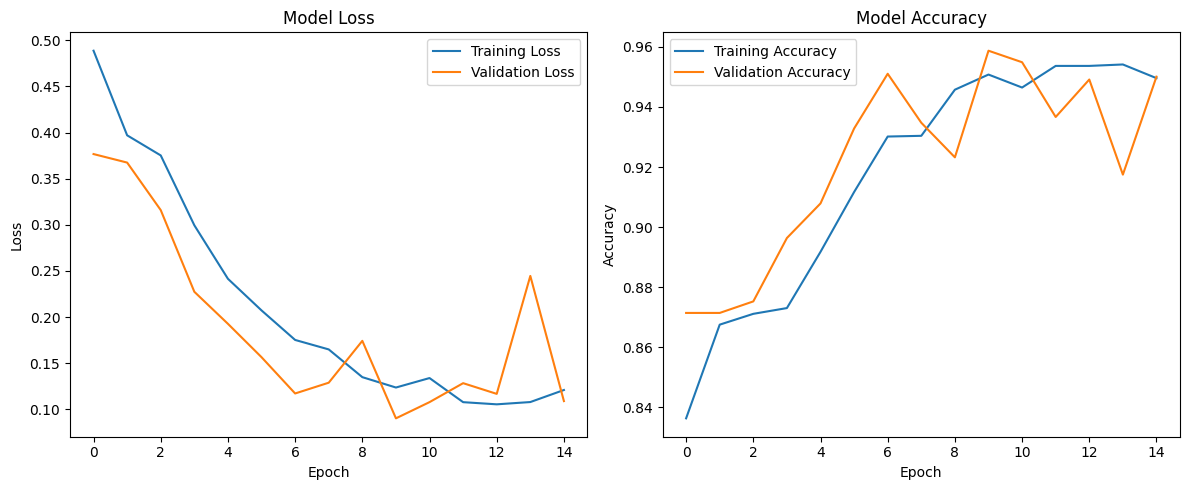

In [21]:
# Initialize and train Layer2
layer2 = AdaptiveNIDSLayer2(
    input_dim=X_features.shape[1],  # Features per timestep
    num_classes=num_classes,
    seq_length=seq_length
)

history_layer2 = layer2.train(
    X_seq_train, y_seq_train,
    X_seq_val, y_seq_val,
    epochs=50,
    batch_size=32
)

# Evaluate performance
evaluation_results = layer2.evaluate_model(X_seq_val, y_seq_val)
print(pd.DataFrame(evaluation_results['classification_report']).transpose())

# Plot training curves
layer2.plot_training_history(history_layer2)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step   accuracy: 0.7932 - loss: 0.
 - val_f1: 0.8115
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7971 - loss: 0.6067 - val_accuracy: 0.8714 - val_loss: 0.3791 - learning_rate: 2.0000e-04
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8508 - loss: 0.468
 - val_f1: 0.8115
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8508 - loss: 0.4680 - val_accuracy: 0.8714 - val_loss: 0.3707 - learning_rate: 4.0000e-04
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  - accuracy: 0.8695 - loss: 0.412
 - val_f1: 0.8115
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8693 - loss: 0.4126 - val_accuracy: 0.8714 - val_loss: 0.3642 - learning_rate: 6.0000e-04
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  - accuracy: 0.8637 - loss: 0.4
 - val_f1: 0.8115
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8640 - loss: 0.4120 - val_accuracy: 0.8714 - val_loss: 0.2986 - learning_rate: 8.0000e-04
Epoch 5/50
33/33 ━━━━━━

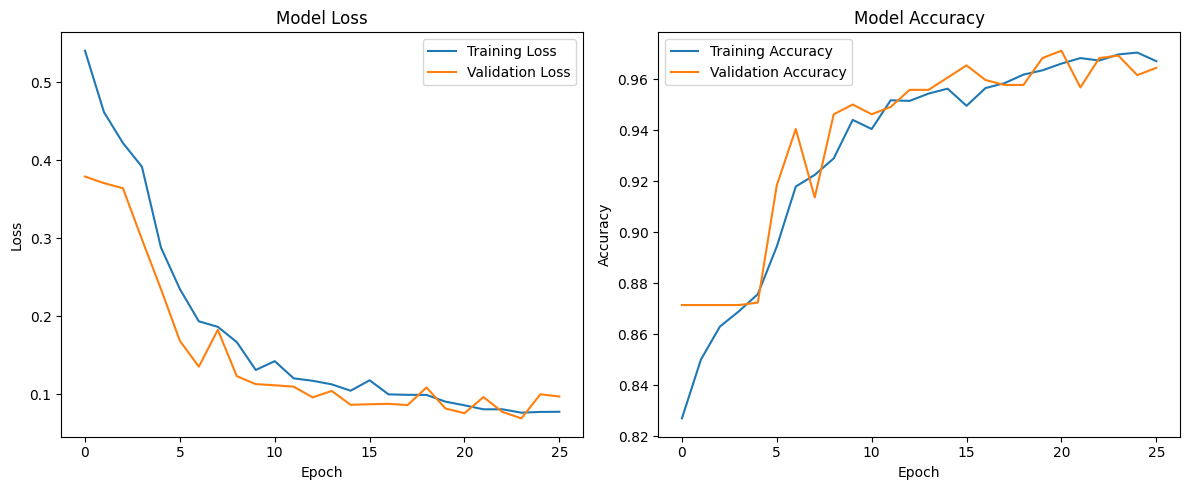

In [22]:
# Initialize and train Layer2
layer2 = AdaptiveNIDSLayer2(
    input_dim=X_features.shape[1],  # Features per timestep
    num_classes=num_classes,
    seq_length=seq_length
)

history_layer2 = layer2.train(
    X_seq_train, y_seq_train,
    X_seq_val, y_seq_val,
    epochs=50,
    batch_size=64
)

# Evaluate performance
evaluation_results = layer2.evaluate_model(X_seq_val, y_seq_val)
print(pd.DataFrame(evaluation_results['classification_report']).transpose())

# Plot training curves
layer2.plot_training_history(history_layer2)